In [1]:
import glob
import pandas as pd
import numpy as np

import os
import os.path as osp
import re
# yes

In [2]:
def get_metric_excel_paths(base_path,metric):
    # Use glob to match all CI.xlsx files in seed_{number} folders
    pattern = os.path.join(base_path, "results_*", "*", "seed_*", f"{metric}.xlsx")
    metric_excel_paths = glob.glob(pattern)
    return metric_excel_paths

def read_metric_data(file_path):
    # Read the CI.xlsx file and extract epsilon and CI values
    df = pd.read_excel(file_path)
    if df.shape[1] != 2:
        raise ValueError(f"Unexpected format in {file_path}. Expected exactly two columns.")

    metric_name = df.columns[-1]
    df.columns = ['epsilon', metric_name]
    return df

def extract_metadata_from_path(path):
    # Extract dataset, algorithm, and attack method from the path
    parts = path.split(os.sep)
    attack_method = parts[-5].replace("attack_", "")
    algorithm = parts[-4].replace("results_", "")
    dataset = parts[-3]
    seed = int(parts[-2].replace("seed_", ""))
    return dataset, algorithm, attack_method, seed

def create_aggregated_dataframe(base_path,metric="CI"):
    # Get all CI.xlsx file paths
    ci_excel_files = get_metric_excel_paths(base_path,metric)
    
    # Dictionary to store dataframes by (dataset, algorithm) keys
    data_dict = {}
    
    # Process each CI.xlsx file
    for file_path in ci_excel_files:
        dataset, algorithm, attack_method, seed = extract_metadata_from_path(file_path)
        metric_data = read_metric_data(file_path)
        
        # Use (dataset, algorithm) as key
        key = (dataset, algorithm)
        
        # Initialize list for the key if not present
        if key not in data_dict:
            data_dict[key] = []
        
        # Append CI data to the list for that key
        data_dict[key].append(metric_data.set_index('epsilon'))
    
    # Dictionary to store aggregated dataframes
    aggregated_data = {}
    
    # Aggregate by dataset and algorithm
    for (dataset, algorithm), dfs in data_dict.items():
        # Concatenate along the columns to align by epsilon values and compute mean
        concatenated_df = pd.concat(dfs, axis=1)
        aggregated_df = concatenated_df.mean(axis=1).to_frame(name=(dataset, algorithm))
        aggregated_data[(dataset, algorithm)] = aggregated_df
    
    # Combine all aggregated dataframes into a single dataframe with multi-index columns
    final_df = pd.concat(aggregated_data.values(), axis=1)

    # Sort the columns by dataset and then by algorithm for a clean MultiIndex
    final_df = final_df.sort_index(axis=1, level=[0, 1])

    # Create a MultiIndex for the columns with levels: dataset and algorithm
    columns = pd.MultiIndex.from_tuples(final_df.columns, names=['Dataset', 'Algorithm'])
    final_df.columns = columns
    
    return final_df


In [3]:
def filter_by_epsilon(df, epsilon_value):
    # Extract the 'epsilon' part from the 'index' (assuming it's part of a string like attack_epsilon_dataset_metric)
    df['epsilon'] = df.index.str.split('_').str[1]
    
    # Filter rows based on the 'epsilon' value
    filtered_df = df[df['epsilon'] == epsilon_value]
    
    # Drop the 'epsilon' column after filtering (if not needed anymore)
    filtered_df = filtered_df.drop(columns=['epsilon'])
    df.drop(columns=['epsilon'],inplace=True)
    
    return filtered_df

In [4]:
def filter_by_metric(df, metric):
    # Extract the 'epsilon' part from the 'index' (assuming it's part of a string like attack_epsilon_dataset_metric)
    df['metric'] = df.index.str.split('_').str[-1]
    
    # Filter rows based on the 'epsilon' value
    filtered_df = df[df['metric'] == metric]
    
    # Drop the 'epsilon' column after filtering (if not needed anymore)
    filtered_df = filtered_df.drop(columns=['metric'])
    df.drop(columns=['metric'],inplace=True)

    return filtered_df

In [5]:
attacks = ["fgsm","crownibp"]
algorithms = ["draft","noise","fgsm","pgd","aae","crownibp"]
exclude_datasets = ["Dialysis","divorce","Pbc3","vlbw"]
metrics = ["CI","IBS","NegLL"]

In [6]:
rename_dict = {"draft":"DRAFT","noise":"Noise","fgsm":"FGSM","pgd":"PGD","aae":"AAE-Cox","crownibp":"SAWAR"}
algorithms_renamed = list(rename_dict.values())

In [7]:
df_all = pd.DataFrame()
df_rank_all = pd.DataFrame()
df_rank_avg = pd.DataFrame()

for attack in attacks:
    for metric in metrics:
        ascending = False if metric=="CI" else True
        
        base_path = osp.join(os.getcwd(),"results")
        attack_folder =  f"attack_{attack}"
        seeds = [str(i*111) for i in range(1,6)]
        results_folder = os.path.join(base_path, attack_folder)
        
        final_df = create_aggregated_dataframe(results_folder,metric).reindex(columns=algorithms, level=1)
        final_df = final_df.rename(columns=rename_dict, level=1)
        final_df[final_df==''] = np.NaN
        final_df = final_df.astype(float)

        if final_df.isna().values.sum()>0:
            if metric =="CI":
                final_df[final_df.isna()] = 0.5
            elif metric == "IBS":
                final_df[final_df.isna()] = 1
            elif metric == "NegLL":
                final_df[final_df.isna()] = np.nanmax(final_df.values)*1.1
                
        
        best_per_dataset_rank = final_df.groupby(level=0,axis=1).rank(axis=1,na_option='bottom',method="average",ascending=ascending).reindex(columns=algorithms_renamed, level=1)
        best_per_dataset_avg_rank = best_per_dataset_rank.stack(level=1).mean(1).unstack(1).sort_values(by="epsilon",ascending=False)


        df1 = final_df.T.reset_index().set_index(['Dataset','Algorithm']).unstack(level='Dataset').T.reset_index()    
        df1["index"] = f"{attack}" + "_" + df1["epsilon"].astype(str) + "_" + df1["Dataset"].astype(str) + "_" + f"{metric}"
        df1 = df1.set_index("index").drop(columns=["epsilon", "Dataset"])
        df_all = pd.concat((df_all,df1))

        df1 = best_per_dataset_rank.T.reset_index().set_index(['Dataset','Algorithm']).unstack(level='Dataset').T.reset_index()    
        df1["index"] = f"{attack}" + "_" + df1["epsilon"].astype(str) + "_" + df1["Dataset"].astype(str) + "_" + f"{metric}"
        df1 = df1.set_index("index").drop(columns=["epsilon", "Dataset"])
        df_rank_all = pd.concat((df_rank_all,df1))

C:\Users\lpott\AppData\Local\Temp\ipykernel_24660\64610233.py:28: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  best_per_dataset_rank = final_df.groupby(level=0,axis=1).rank(axis=1,na_option='bottom',method="average",ascending=ascending).reindex(columns=algorithms_renamed, level=1)
C:\Users\lpott\AppData\Local\Temp\ipykernel_24660\64610233.py:28: FutureWarning: DataFrameGroupBy.rank with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  best_per_dataset_rank = final_df.groupby(level=0,axis=1).rank(axis=1,na_option='bottom',method="average",ascending=ascending).reindex(columns=algorithms_renamed, level=1)
C:\Users\lpott\AppData\Local\Temp\ipykernel_24660\64610233.py:29: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to

## STATISTICAL TESTS!

In [8]:
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
import matplotlib.pyplot as plt

Friedman test statistic: 12.799999999999983, p-value: 0.02532683564059122
The results are statistically significant.
Posthoc Nemenyi test results:
           AAE-Cox     DRAFT      FGSM     Noise       PGD     SAWAR
AAE-Cox  1.000000  0.407141  0.058357  0.067007  0.102651  0.793816
DRAFT    0.407141  1.000000  0.260758  0.325522  0.407141  0.325522
FGSM     0.058357  0.260758  1.000000  0.793816  0.751985  0.058357
Noise    0.067007  0.325522  0.793816  1.000000  0.793816  0.058357
PGD      0.102651  0.407141  0.751985  0.793816  1.000000  0.067007
SAWAR    0.793816  0.325522  0.058357  0.058357  0.067007  1.000000
Friedman test statistic: 19.14285714285714, p-value: 0.0018078433157045991
The results are statistically significant.
Posthoc Nemenyi test results:
           AAE-Cox     DRAFT      FGSM     Noise       PGD     SAWAR
AAE-Cox  1.000000  0.829452  0.010127  0.033889  0.010127  0.769701
DRAFT    0.829452  1.000000  0.012773  0.059540  0.012773  0.592775
FGSM     0.010127  0.01

C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


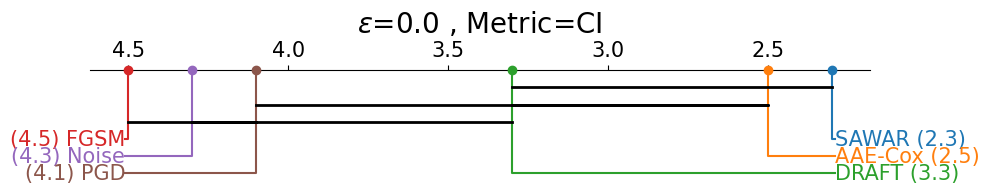

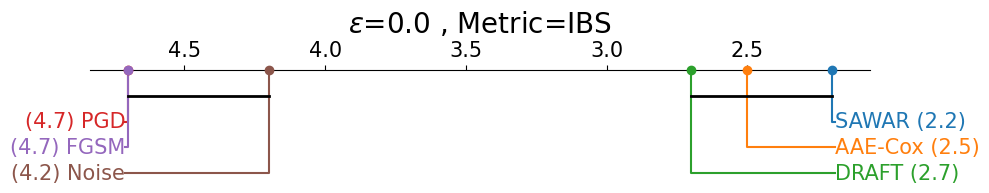

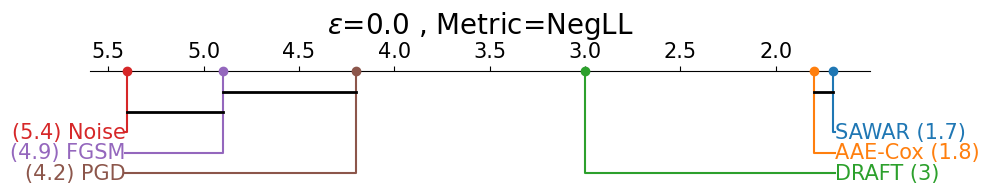

In [52]:
epsilon_filter = "0.0"

for metric in metrics: #metric = "NegLL"
    temp_df = filter_by_metric(filter_by_epsilon(df_all,epsilon_filter).drop_duplicates(),metric=metric)
    temp_rank_df = filter_by_metric(filter_by_epsilon(df_rank_all,epsilon_filter),metric=metric)
    temp_rank_df = temp_rank_df.iloc[:temp_rank_df.shape[0]//2]
    
    # Perform Friedman test
    stat, p_value = friedmanchisquare(*temp_df.values.T)  # Transpose for algorithms
    print(f"Friedman test statistic: {stat}, p-value: {p_value}")
    
    # Check significance
    if p_value < 0.05:
        print("The results are statistically significant.")
    
    # Posthoc Nemenyi test
    conover_results = sp.posthoc_conover_friedman(temp_df,p_adjust ="fdr_bh")  # Transpose for algorithms
    print("Posthoc Nemenyi test results:\n", conover_results)
    
    plt.figure(figsize=(10,2))
    
    
    cd_obj = sp.critical_difference_diagram(temp_rank_df.mean(axis=0), conover_results,alpha=0.1) #,label_props  = dict(zip(["0","1","2"],labels)))
    for text_box in cd_obj['labels']:
        text_box.set_fontsize(15)
    
    # Invert text label alignments based on current alignment
    for label in cd_obj['labels']:
        current_alignment = label.get_horizontalalignment()
        if current_alignment == 'left':
            label.set_horizontalalignment('right')  # Flip left to right
        elif current_alignment == 'right':
            label.set_horizontalalignment('left')  # Flip right to left
        
    # Adjust font sizes here:
    plt.title(f"$\epsilon$={epsilon_filter} , Metric={metric}", fontsize=20)  # Title font size
    plt.xticks(fontsize=15)  # X-axis tick font size
    plt.yticks(fontsize=15)  # Y-axis tick font size
    plt.gca().invert_xaxis()
    plt.tight_layout()  # Ensure the layout is tight with the smaller font

### Statistical test for all perturbations and attacks

In [76]:
cwd = os.getcwd()
save_folder = osp.join(cwd,"results",f"adv_critical_diagram.pdf")

Friedman test statistic: 273.35656421253316, p-value: 5.321656203550075e-57
The results are statistically significant.
Posthoc Conover test results:
               AAE-Cox         DRAFT          FGSM         Noise           PGD  \
AAE-Cox  1.000000e+00  2.066917e-01  8.898060e-01  2.229204e-04  1.872292e-01   
DRAFT    2.066917e-01  1.000000e+00  2.444949e-01  1.635099e-02  9.049896e-03   
FGSM     8.898060e-01  2.444949e-01  1.000000e+00  3.399885e-04  1.560226e-01   
Noise    2.229204e-04  1.635099e-02  3.399885e-04  1.000000e+00  2.850616e-07   
PGD      1.872292e-01  9.049896e-03  1.560226e-01  2.850616e-07  1.000000e+00   
SAWAR    4.524326e-36  9.775960e-43  1.216538e-36  6.791739e-57  2.888417e-29   

                SAWAR  
AAE-Cox  4.524326e-36  
DRAFT    9.775960e-43  
FGSM     1.216538e-36  
Noise    6.791739e-57  
PGD      2.888417e-29  
SAWAR    1.000000e+00  
Friedman test statistic: 539.5555688479486, p-value: 2.302939076183902e-114
The results are statistically signific

C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Friedman test statistic: 647.2333333333336, p-value: 1.2545529030993698e-137
The results are statistically significant.
Posthoc Conover test results:
               AAE-Cox          DRAFT          FGSM          Noise  \
AAE-Cox  1.000000e+00   2.002559e-04  6.237643e-02   2.713350e-48   
DRAFT    2.002559e-04   1.000000e+00  6.162052e-02   2.828587e-29   
FGSM     6.237643e-02   6.162052e-02  1.000000e+00   2.003297e-38   
Noise    2.713350e-48   2.828587e-29  2.003297e-38   1.000000e+00   
PGD      3.452309e-09   1.621002e-21  1.197941e-14   2.555982e-85   
SAWAR    5.714368e-79  2.492230e-104  2.795121e-91  1.291884e-189   

                  PGD          SAWAR  
AAE-Cox  3.452309e-09   5.714368e-79  
DRAFT    1.621002e-21  2.492230e-104  
FGSM     1.197941e-14   2.795121e-91  
Noise    2.555982e-85  1.291884e-189  
PGD      1.000000e+00   4.650185e-43  
SAWAR    4.650185e-43   1.000000e+00  


C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


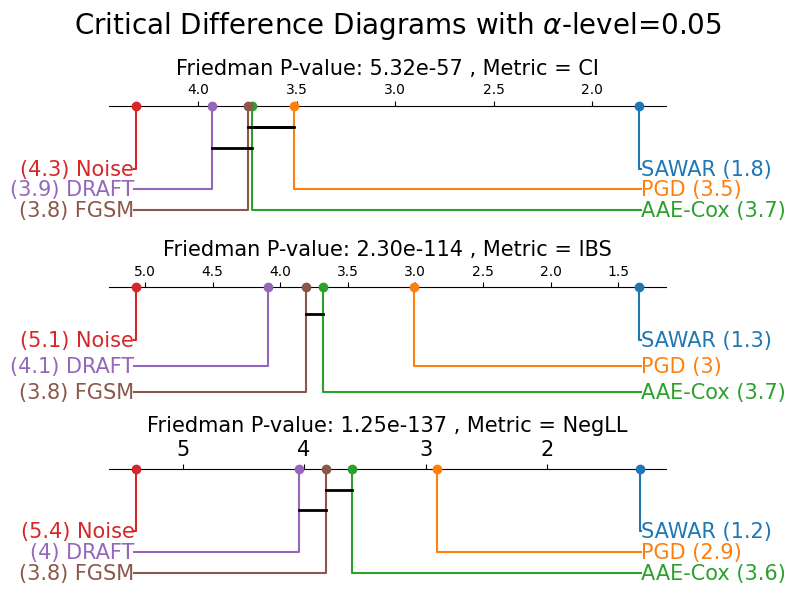

In [77]:
fig,axes = plt.subplots(3,1,figsize=(8,6))
alpha=0.05
for ax,metric in zip(axes,metrics):
    temp_df = filter_by_metric(df_all,metric=metric)
    temp_rank_df = filter_by_metric(df_rank_all,metric=metric)

    # Perform Friedman test
    stat, p_value = friedmanchisquare(*temp_df.values.T[:50])  # Transpose for algorithms
    print(f"Friedman test statistic: {stat}, p-value: {p_value}")
    
    # Check significance
    if p_value < 0.05:
        print("The results are statistically significant.")
    
    # Posthoc Nemenyi test
    conover_results = sp.posthoc_conover_friedman(temp_df,p_adjust ="fdr_bh")  # Transpose for algorithms
    print("Posthoc Conover test results:\n", conover_results)

    
    
    cd_obj = sp.critical_difference_diagram(temp_rank_df.mean(axis=0), conover_results,alpha=alpha,ax=ax) #,label_props  = dict(zip(["0","1","2"],labels)))
    for text_box in cd_obj['labels']:
        text_box.set_fontsize(15)
    
    # Invert text label alignments based on current alignment
    for label in cd_obj['labels']:
        current_alignment = label.get_horizontalalignment()
        if current_alignment == 'left':
            label.set_horizontalalignment('right')  # Flip left to right
        elif current_alignment == 'right':
            label.set_horizontalalignment('left')  # Flip right to left
        
    # Adjust font sizes here:

    ax.set_title(f"Friedman P-value: {p_value:.2e} , Metric = {metric}", fontsize=15)  # Title font size
    plt.xticks(fontsize=15)  # X-axis tick font size
    plt.yticks(fontsize=15)  # Y-axis tick font size
    ax.invert_xaxis()

fig.suptitle(f"Critical Difference Diagrams with $\\alpha$-level={alpha}",fontsize=20)
fig.tight_layout()  # Ensure the layout is tight with the smaller font
plt.savefig(save_folder)